In [23]:
import os

os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'
import xarray as xr
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as pltt
%matplotlib inline
import numpy as np
import intake
import fsspec
import xmitgcm
from scipy.signal import detrend

In [3]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
ds_faces2 = xr.open_zarr(fsspec.get_mapper('gcs://pangeo-data/ECCO_layers.zarr'))
ds_faces=xr.merge((ds_faces1,ds_faces2))

In [53]:
coords.hFacS

<xarray.DataArray 'hFacS' (k: 50, j_g: 270, i: 360)>
dask.array<concatenate, shape=(50, 270, 360), dtype=float32, chunksize=(50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
Attributes:
    long_name:      vertical fraction of open cell
    standard_name:  cell_vertical_fraction_at_v_location

In [4]:
#for more info on how this mask works, see https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/get_basin.py
all_basins = xmitgcm.utils.read_3d_llc_data('/home/jovyan/basins.data', nx=90,nz=1,nrecs=1,dtype='>f')
mask_2d = ds_faces['hFacC'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacC','maskC'])
ds_with_mask=xr.merge((ds_faces,basin_mask.rename('atl_maskC')))
mask_2d = ds_faces['hFacS'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacS','maskS'])
ds_with_mask2=xr.merge((ds_with_mask,basin_mask.rename('atl_maskS')))
mask_2d = ds_faces['hFacW'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(all_basins.squeeze() == 2,0)+ mask_2d.where(all_basins.squeeze() == 7,0)
              + mask_2d.where(all_basins.squeeze() == 9,0)
             + mask_2d.where(all_basins.squeeze() == 10,0)
             + mask_2d.where(all_basins.squeeze() == 12,0)
             + mask_2d.where(all_basins.squeeze() == 18,0)
             + mask_2d.where(all_basins.squeeze() == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacW','maskW'])
ds_with_mask3=xr.merge((ds_with_mask2,basin_mask.rename('atl_maskW')))

In [5]:
ds_ll = faces_dataset_to_latlon(ds_with_mask3, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO'),('atl_maskW','atl_maskS')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [6]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time.values[1:-1] 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [55]:
#Piecuch's throughflow 

v = (ds.VVELMASS[:, :, 212, :] * coords.drF * coords.dxG[212, :] * ds.atl_maskS[212, :]).sum(['i','k'])
t = (ds.THETA[:, :, 212, :] * coords.drF * coords.dxG[212, :] * ds.atl_maskS[212, :]).sum(['i','k'])
a = (coords.drF * coords.dxG[212, :] * ds.atl_maskS[212, :] * coords.hFacS[:, 212, :]).sum(['i','k'])
p_throughflow = (v*t).cumsum('time') / a #has units of degCm^3/s- should i do a minus (v*t[time 0])? 
p_throughflow.load()

<xarray.DataArray (time: 288)>
array([-9.01307300e+06, -2.09960240e+07, -3.17353260e+07, -4.27273160e+07,
       -5.42400560e+07, -7.04035440e+07, -8.39621280e+07, -9.22319360e+07,
       -9.49094000e+07, -1.05429840e+08, -1.13628328e+08, -1.19425712e+08,
       -1.31437232e+08, -1.46205712e+08, -1.51355728e+08, -1.66536608e+08,
       -1.82252208e+08, -1.94639088e+08, -2.08466400e+08, -2.19887568e+08,
       -2.27967440e+08, -2.40006080e+08, -2.45144608e+08, -2.54450224e+08,
       -2.69387808e+08, -2.82214848e+08, -2.86570528e+08, -2.94570752e+08,
       -3.07178976e+08, -3.17111456e+08, -3.30488256e+08, -3.43982208e+08,
       -3.45520352e+08, -3.50797952e+08, -3.55268704e+08, -3.60835136e+08,
       -3.71489248e+08, -3.82560320e+08, -3.92352480e+08, -4.03352096e+08,
       -4.19829632e+08, -4.32933920e+08, -4.46943072e+08, -4.56421344e+08,
       -4.69685312e+08, -4.80205888e+08, -4.91084864e+08, -5.00110880e+08,
       -5.12907296e+08, -5.23989056e+08, -5.39184832e+08, -5.48023616

In [64]:
#Overturning
v = (ds.VVELMASS[:, :, 212, :] * coords.dxG[212, :] * ds.atl_maskS[212, :]).sum('i')
t = (ds.THETA[:, :, 212, :] * coords.dxG[212, :] * ds.atl_maskS[212, :]).sum('i')
a = (coords.dxG[212, :] * ds.atl_maskS[212, :] * coords.hFacS[:, 212, :]).sum('i')
ov = (((v * t * coords.drF)/a).sum('k')).cumsum('time')
p_overturning = ov - p_throughflow  #also has units of degCm^3/s
p_overturning.load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


<xarray.DataArray (time: 288)>
array([8.4589064e+07, 1.5791200e+08, 2.4305184e+08, 3.0898634e+08,
       4.0192845e+08, 4.8832342e+08, 5.5858579e+08, 6.3856768e+08,
       7.5194170e+08, 8.5371238e+08, 9.1602912e+08, 1.0065862e+09,
       1.0737060e+09, 1.1998953e+09, 1.2932140e+09, 1.3849400e+09,
       1.4681844e+09, 1.5505059e+09, 1.6472317e+09, 1.7386153e+09,
       1.8237261e+09, 1.9310605e+09, 2.0429775e+09, 2.1425457e+09,
       2.2346130e+09, 2.2498452e+09, 2.3432681e+09, 2.4587781e+09,
       2.5329339e+09, 2.6405135e+09, 2.7304901e+09, 2.8117043e+09,
       2.9028859e+09, 2.9988500e+09, 3.0661550e+09, 3.1550610e+09,
       3.2349258e+09, 3.3064261e+09, 3.4234504e+09, 3.4984829e+09,
       3.5490529e+09, 3.6767109e+09, 3.7657544e+09, 3.8523041e+09,
       3.9740372e+09, 4.0858783e+09, 4.1881004e+09, 4.2075000e+09,
       4.2544323e+09, 4.3623485e+09, 4.4546355e+09, 4.5365934e+09,
       4.6509097e+09, 4.7586877e+09, 4.8814484e+09, 4.9879644e+09,
       5.0819651e+09, 5.1980595

In [65]:
#Gyre
tot = (ds.ADVy_TH[:, :, 212, :] * ds.atl_maskS[212, :]).sum(['i','k'])
p_gyre = tot - p_overturning - p_throughflow
p_gyre.load()

<xarray.DataArray (time: 288)>
array([ 2.8200584e+07, -5.1645400e+07, -1.1324973e+08, -1.7836472e+08,
       -2.1135059e+08, -2.8196771e+08, -3.5231206e+08, -4.0897011e+08,
       -4.7825923e+08, -5.9394669e+08, -7.0034592e+08, -7.6397318e+08,
       -8.5533286e+08, -8.9351872e+08, -1.0162627e+09, -1.0906684e+09,
       -1.1587461e+09, -1.2217772e+09, -1.2847551e+09, -1.3660774e+09,
       -1.4432457e+09, -1.5284285e+09, -1.6459845e+09, -1.7576626e+09,
       -1.8824863e+09, -1.9498696e+09, -1.9432340e+09, -2.0207631e+09,
       -2.0998336e+09, -2.1543977e+09, -2.2466504e+09, -2.3283169e+09,
       -2.4041564e+09, -2.4946831e+09, -2.6061233e+09, -2.6617889e+09,
       -2.7572045e+09, -2.8423119e+09, -2.8864868e+09, -2.9927204e+09,
       -3.0339671e+09, -3.0628052e+09, -3.1687432e+09, -3.2433070e+09,
       -3.3204792e+09, -3.4411735e+09, -3.5358157e+09, -3.6426045e+09,
       -3.6705121e+09, -3.7049144e+09, -3.8022597e+09, -3.8762345e+09,
       -3.9270733e+09, -4.0286523e+09, -4.1212

In [66]:
#detrending
tf_detrend = xr.apply_ufunc(detrend, p_throughflow.load().fillna(0),kwargs={'axis': 0}).where(~p_throughflow.isnull())
ov_detrend = xr.apply_ufunc(detrend, p_overturning.load().fillna(0),kwargs={'axis': 0}).where(~p_overturning.isnull())
gyre_detrend = xr.apply_ufunc(detrend, p_gyre.load().fillna(0),kwargs={'axis': 0}).where(~p_gyre.isnull())

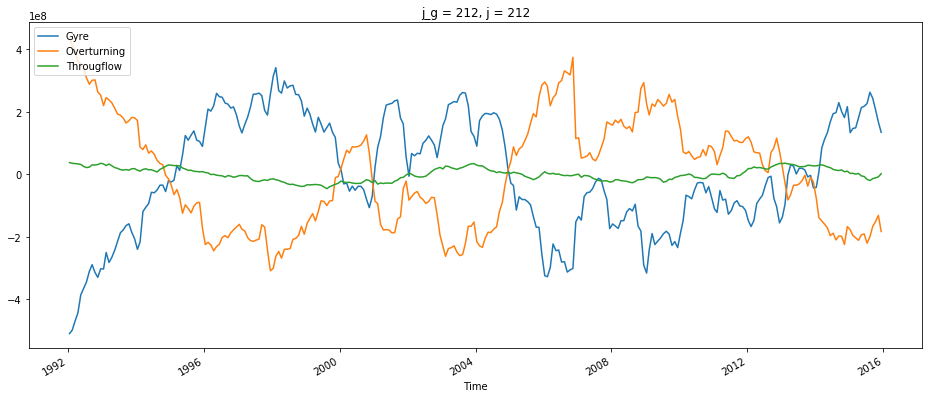

In [67]:
fig, ax = pltt.subplots(figsize=(16,6))
(gyre_detrend).plot(ax=ax)
(ov_detrend).plot(ax=ax)
(tf_detrend).plot(ax=ax)
ax.legend(("Gyre", "Overturning", "Througflow"),loc='upper left')

In [68]:
#Removing seasons from detrended 
month_tf = tf_detrend.groupby('time.month').mean('time')
month_ov = ov_detrend.groupby('time.month').mean('time')
month_gyre = gyre_detrend.groupby('time.month').mean('time')

tf_ds = tf_detrend.groupby('time.month') - month_tf
ov_ds = ov_detrend.groupby('time.month') - month_ov
gyre_ds = gyre_detrend.groupby('time.month') - month_gyre

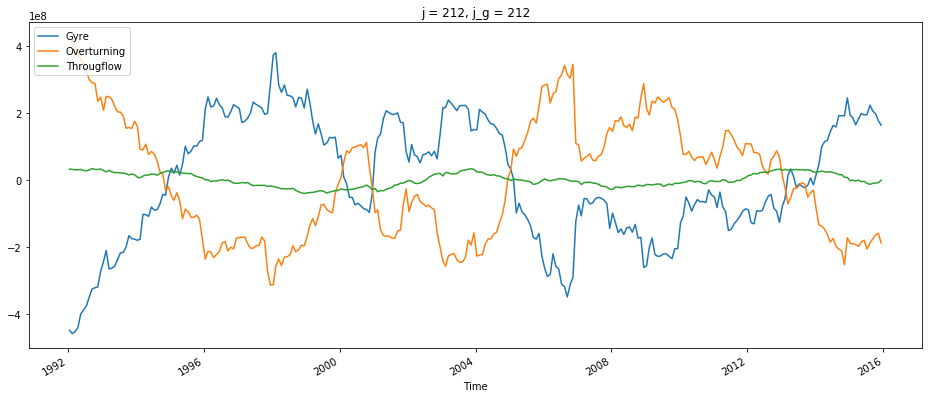

In [69]:
fig, ax = pltt.subplots(figsize=(16,6))
(gyre_ds).plot(ax=ax)
(ov_ds).plot(ax=ax)
(tf_ds).plot(ax=ax)
ax.legend(("Gyre", "Overturning", "Througflow"),loc='upper left')

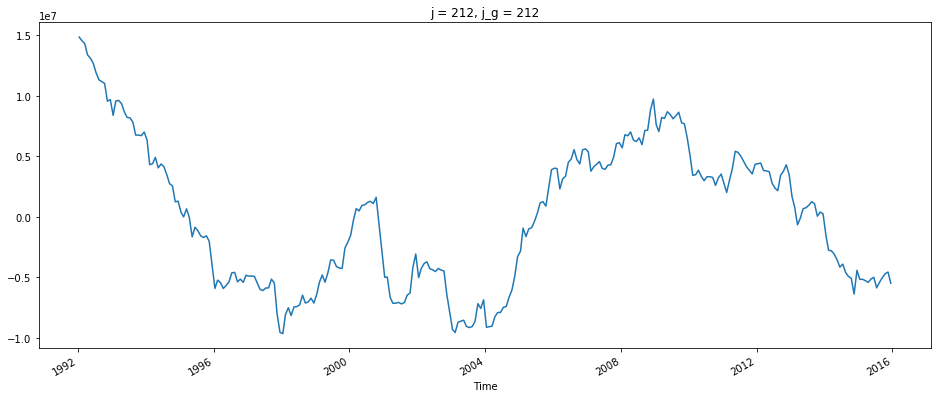

In [63]:
(ov_ds + tf_ds).plot(figsize=(16,6))